In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month, year

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("AdvancedAnalytics").getOrCreate()

# Load Parquet data
df = spark.read.parquet("data/synthetic_faker_transactions_20K.parquet")

# Add month and year columns for trend analysis
df = df.withColumn("month", month(col("purchase_date")))
df = df.withColumn("year", year(col("purchase_date")))

# Cache the data for faster processing
df.cache()

# Show a summary of the data
df.describe().show()

25/04/22 13:36:12 WARN Utils: Your hostname, DESKTOP-06R9Q15 resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/04/22 13:36:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/22 13:36:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/22 13:36:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

+-------+--------------------+-------+-------+-----------------+-------------+------------+--------------+-----------------+------------------+
|summary|      transaction_id|user_id|product|            price|purchase_date|    location|payment_method|            month|              year|
+-------+--------------------+-------+-------+-----------------+-------------+------------+--------------+-----------------+------------------+
|  count|               20000|  20000|  20000|            20000|        20000|       20000|         20000|            20000|             20000|
|   mean|                NULL|   NULL|   NULL|773.4103790000022|         NULL|        NULL|          NULL|          6.54025|        2024.30115|
| stddev|                NULL|   NULL|   NULL|417.7840684763245|         NULL|        NULL|          NULL|3.443642384328488|0.4587692240768243|
|    min|00037c3f-5b27-482...| aadams|Charger|            50.06|   2024-04-21|Aaronborough| Bank Transfer|                1|            

In [3]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# Prepare features for clustering
assembler = VectorAssembler(inputCols=["price", "month"], outputCol="features")
data = assembler.transform(df)

# Apply K-means clustering
kmeans = KMeans(k=5, seed=1)
model = kmeans.fit(data)

# Show cluster centers
centers = model.clusterCenters()
print("Cluster Centers:", centers)

25/04/22 13:37:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Cluster Centers: [array([778.39550597,   6.50816874]), array([1071.16336807,    6.52694459]), array([195.05947967,   6.66077292]), array([486.52375728,   6.49951456]), array([1360.09587236,    6.50797735])]


In [5]:
## MOnthly sales trends:
from pyspark.sql.functions import month, year, col, sum

# Aggregate sales by month and year
monthly_sales = df.groupBy("year", "month").agg(sum("price").alias("total_sales"))

# Convert PySpark DataFrame to Pandas for plotting
sales_pd = monthly_sales.toPandas()

In [7]:
## Price distribution across products
from pyspark.sql.functions import avg

# Calculate average price per product
price_dist = df.groupBy("product").agg(avg("price").alias("avg_price"))

# Convert PySpark DataFrame to Pandas for plotting
price_pd = price_dist.toPandas()

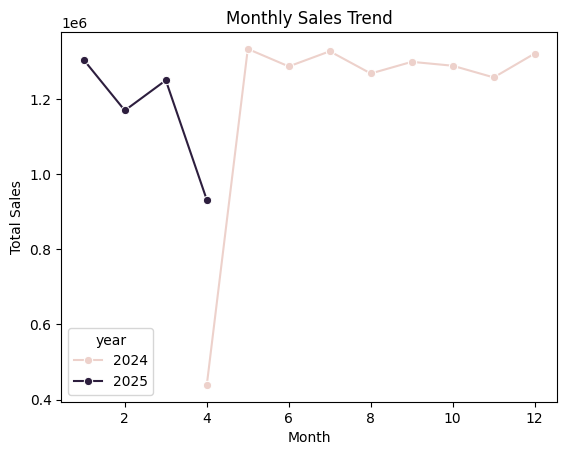

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Line plot for monthly sales
sns.lineplot(data=sales_pd, x="month", y="total_sales", hue="year", marker="o")
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.show()

/tmp/ipykernel_8316/4128725354.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=price_pd, x="product", y="avg_price", palette="viridis")


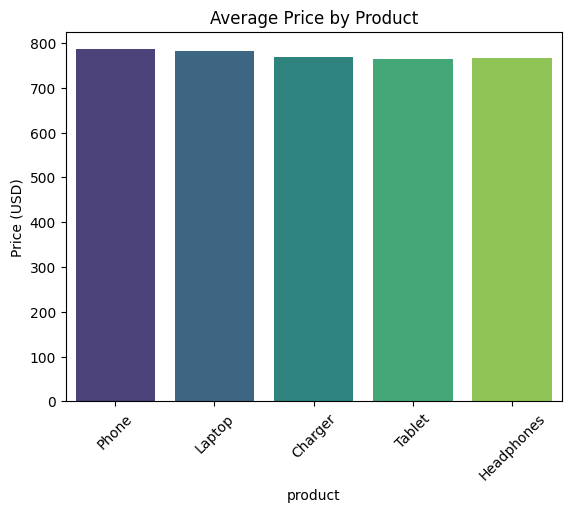

In [10]:
# Bar chart for average price by product
sns.barplot(data=price_pd, x="product", y="avg_price", palette="viridis")
plt.title("Average Price by Product")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.show()

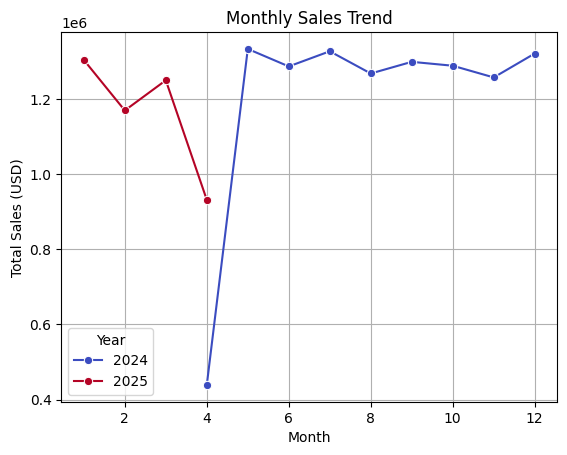

In [13]:
# Line plot for monthly sales trend
sns.lineplot(data=sales_pd, x="month", y="total_sales", hue="year", marker="o", palette="coolwarm")
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales (USD)")
plt.grid(True)
plt.legend(title="Year")
plt.show()

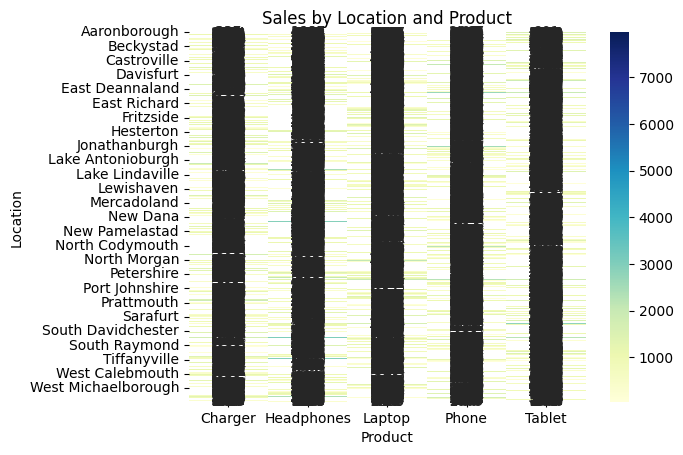

In [15]:
# Prepare location-product sales data
location_product_sales = df.groupBy("location", "product").agg(sum("price").alias("total_sales")).toPandas()

# Pivot data for heatmap
pivot_data = location_product_sales.pivot(index="location", columns="product", values="total_sales")

# Heatmap
sns.heatmap(pivot_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Sales by Location and Product")
plt.xlabel("Product")
plt.ylabel("Location")
plt.show()

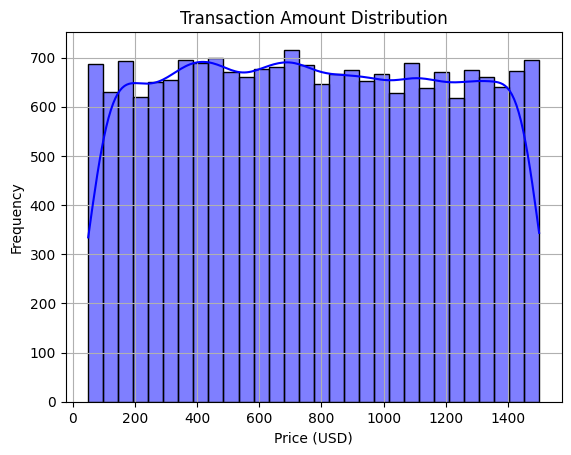

In [16]:
# Histogram for transaction amounts
sns.histplot(df.toPandas()["price"], bins=30, kde=True, color="blue")
plt.title("Transaction Amount Distribution")
plt.xlabel("Price (USD)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

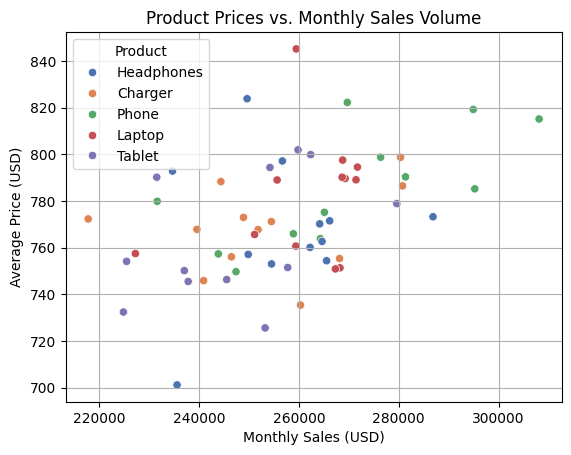

In [20]:
# Scatter plot for price vs. sales volume
volume_price = df.groupBy("product", "month").agg(sum("price").alias("monthly_sales"), avg("price").alias("avg_price")).toPandas()

sns.scatterplot(data=volume_price, x="monthly_sales", y="avg_price", hue="product", palette="deep")
plt.title("Product Prices vs. Monthly Sales Volume")
plt.xlabel("Monthly Sales (USD)")
plt.ylabel("Average Price (USD)")
plt.grid(True)
plt.legend(title="Product")
plt.show()